# I. 📊 Analyse des ventes de pizzas

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def creer_vues_et_index(conn):
    """
    Crée une vue résumant les ventes et un index pour optimiser les requêtes
    """
    cursor = conn.cursor()

    # Création de la vue synthétique
    cursor.execute("""
    CREATE VIEW IF NOT EXISTS pizza_sales_summary AS
    SELECT
        o.date,                  
        p.pizza_id,
        pt.name AS pizza_name,
        pt.category,
        SUM(od.quantity * p.price) AS total_ventes
    FROM orders o
    JOIN order_details od ON o.order_id = od.order_id
    JOIN pizza p ON od.pizza_id = p.pizza_id
    JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id
    GROUP BY o.date, p.pizza_id, pt.name, pt.category
    ORDER BY o.date, p.pizza_id;
    """)
    print("✅ Vue pizza_sales_summary créée avec succès")

    # Création de l'index
    cursor.execute("""
    CREATE INDEX IF NOT EXISTS idx_order_pizza
    ON order_details (order_id, pizza_id);
    """)
    print("✅ Index idx_order_pizza créé avec succès")
    
    conn.commit()
    cursor.close()

In [4]:
def afficher_top_pizzas(conn):
    """
    Affiche le top 5 des pizzas par revenu avec visualisation
    """
    query = """
    SELECT pizza_name, SUM(total_ventes) AS revenu_total
    FROM pizza_sales_summary
    GROUP BY pizza_name
    ORDER BY revenu_total DESC
    LIMIT 5;
    """
    df = pd.read_sql_query(query, conn)
    
    # Affichage du tableau
    display(df.style
            .background_gradient(cmap='Oranges')
            .set_caption("Top 5 des pizzas par revenu"))
    
    # Visualisation
    plt.figure(figsize=(12,6))
    bars = plt.barh(df['pizza_name'], df['revenu_total'], color='darkorange')
    plt.title("Top 5 des pizzas par revenu généré", pad=20, fontsize=14)
    plt.xlabel("Revenu total (USD)", labelpad=10)
    
    # Ajout des valeurs sur les barres
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                 f'${width:,.2f}', 
                 ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

In [5]:
def afficher_ventes_par_jour(conn):
    """
    Affiche l'évolution des ventes quotidiennes
    """
    query = """
    SELECT date, SUM(total_ventes) AS revenu_journalier
    FROM pizza_sales_summary
    GROUP BY date
    ORDER BY date;
    """
    df = pd.read_sql_query(query, conn)
    df['date'] = pd.to_datetime(df['date'])  # Conversion en datetime
    
    # Affichage du tableau
    display(df.style
            .format({'revenu_journalier': '${:,.2f}'})
            .set_caption("Revenu journalier"))
    
    # Visualisation
    plt.figure(figsize=(14,6))
    plt.plot(df['date'], df['revenu_journalier'], 
             marker='o', 
             linestyle='-', 
             color='steelblue',
             linewidth=2)
    
    plt.title("Évolution du revenu quotidien", pad=20, fontsize=14)
    plt.xlabel("Date", labelpad=10)
    plt.ylabel("Revenu (USD)", labelpad=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Formatage de l'axe des x
    plt.gcf().autofmt_xdate()
    
    plt.tight_layout()
    plt.show()

In [6]:
def afficher_repartition_par_categorie(conn):
    """
    Affiche la répartition des ventes par catégorie
    """
    query = """
    SELECT category, SUM(total_ventes) AS revenu_total
    FROM pizza_sales_summary
    GROUP BY category
    ORDER BY revenu_total DESC;
    """
    df = pd.read_sql_query(query, conn)
    
    # Affichage du tableau
    display(df.style
            .format({'revenu_total': '${:,.2f}'})
            .set_caption("Revenu par catégorie"))
    
    # Visualisation
    plt.figure(figsize=(10,8))
    
    # Palette de couleurs
    colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#D4A5A5']
    
    # Pie chart
    patches, texts, autotexts = plt.pie(
        df['revenu_total'], 
        labels=df['category'], 
        colors=colors,
        autopct='%1.1f%%', 
        startangle=140,
        textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'white', 'linewidth': 1}
    )
    
    # Amélioration des pourcentages
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_weight('bold')
    
    plt.title("Répartition des revenus par catégorie", pad=20, fontsize=14)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

#### Fonction principale exécutant toutes les analyses

In [ ]:
def main():
    conn = None
    try:
        # Connexion à la base
        conn = sqlite3.connect('pizza.db')
        print("🔌 Connexion à la base de données établie")
        
        # Préparation des données
        creer_vues_et_index(conn)
        
        # Analyses
        afficher_top_pizzas(conn)
        afficher_ventes_par_jour(conn)
        afficher_repartition_par_categorie(conn)
        
    except sqlite3.Error as e:
        print(f"❌ Erreur SQLite : {e}")
    finally:
        if conn:
            conn.close()
            print("🔌 Connexion à la base de données fermée")

#### Exécution de l'analyse complète

🔌 Connexion à la base de données établie
✅ Vue pizza_sales_summary créée avec succès
✅ Index idx_order_pizza créé avec succès


,pizza_name,revenu_total
0,The Thai Chicken Pizza,43434.250000
1,The Barbecue Chicken Pizza,42768.000000
2,The California Chicken Pizza,41409.500000
3,The Classic Deluxe Pizza,38180.500000
4,The Spicy Italian Pizza,34831.250000


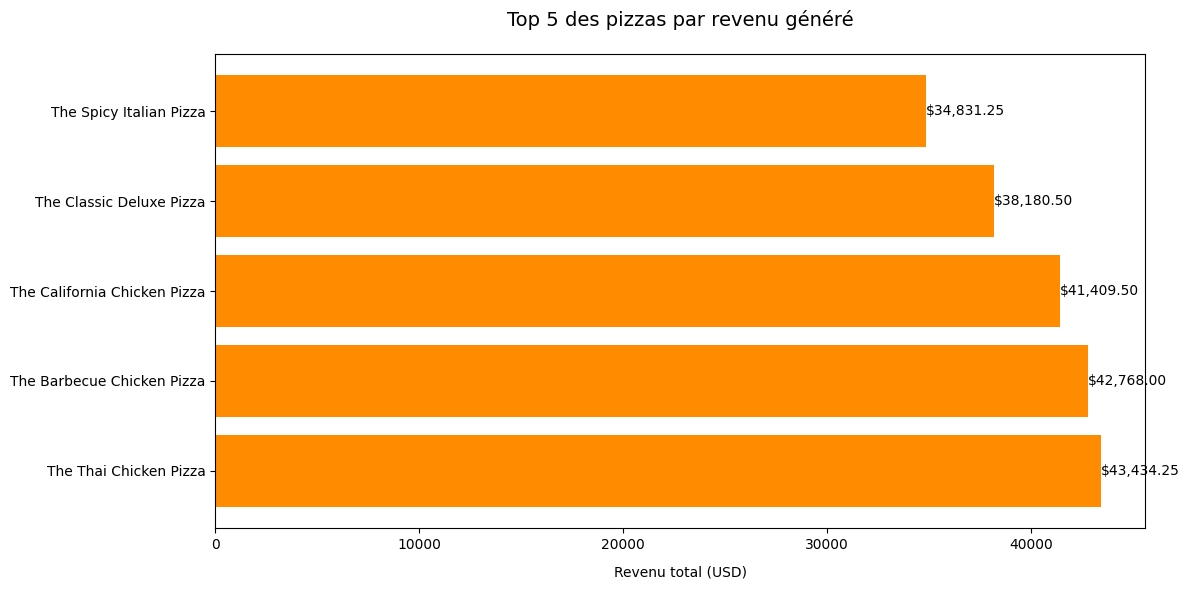

,date,revenu_journalier
0,2015-01-01 00:00:00,"$2,713.85"
1,2015-01-02 00:00:00,"$2,731.90"
2,2015-01-03 00:00:00,"$2,662.40"
3,2015-01-04 00:00:00,"$1,755.45"
4,2015-01-05 00:00:00,"$2,065.95"
5,2015-01-06 00:00:00,"$2,428.95"
6,2015-01-07 00:00:00,"$2,202.20"
7,2015-01-08 00:00:00,"$2,838.35"
8,2015-01-09 00:00:00,"$2,127.35"
9,2015-01-10 00:00:00,"$2,463.95"


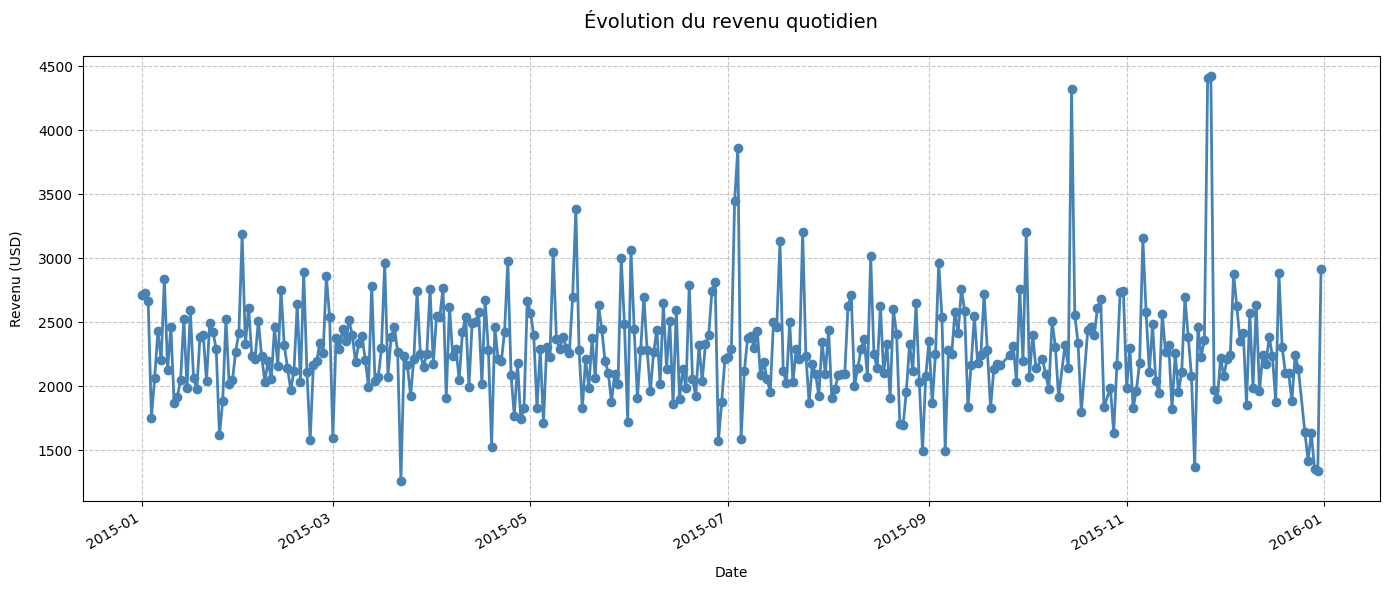

,category,revenu_total
0,Classic,"$220,053.10"
1,Supreme,"$208,197.00"
2,Chicken,"$195,919.50"
3,Veggie,"$193,690.45"


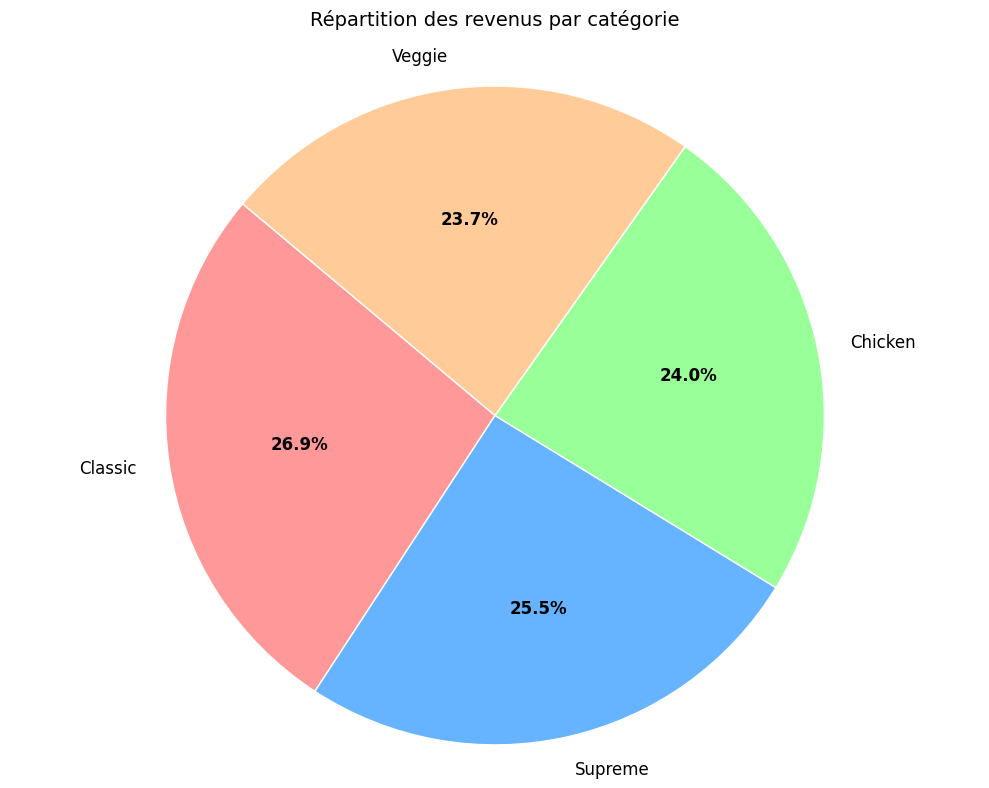

🔌 Connexion à la base de données fermée


In [ ]:
main()

# II. 🛒 Prévision quotidienne des ingrédients nécessaires

- Étape 1 : Extraire les pizzas commandées et leurs ingrédients

In [16]:

# Connexion à la base
conn = sqlite3.connect("pizza.db")

# Requête : on récupère les pizzas commandées, leur quantité et leurs ingrédients
query = """
SELECT
    od.quantity,
    pt.ingredients
FROM order_details od
JOIN pizzas p ON od.pizza_id = p.pizza_id
JOIN pizza_types pt ON p.pizza_type_id = pt.pizza_type_id;
"""

# Chargement dans un DataFrame
df = pd.read_sql_query(query, conn)

# Aperçu
df.head()


,quantity,ingredients
0,1,"Sliced Ham, Pineapple, Mozzarella Cheese"
1,1,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
2,1,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."
3,1,"Calabrese Salami, Capocollo, Tomatoes, Red Oni..."
4,1,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."


- Étape 2 : Traiter les données pour obtenir la consommation totale d’ingrédients

Compter combien de fois chaque ingrédient a été utilisé dans toutes les commandes.

In [17]:
from collections import Counter

In [18]:
# Liste pour stocker tous les ingrédients utilisés
tous_les_ingredients = []

# Parcours de chaque ligne du DataFrame
for _, row in df.iterrows():
    ingredients = [i.strip() for i in row['ingredients'].split(',')]  # Nettoyage des ingrédients
    tous_les_ingredients.extend(ingredients * row['quantity'])  # Ajouter chaque ingrédient selon la quantité commandée

# Compter les ingrédients
compte_ingredients = Counter(tous_les_ingredients)

# Convertir en DataFrame pour affichage trié
df_ingredients = pd.DataFrame(compte_ingredients.items(), columns=['ingredient', 'quantité_utilisée'])
df_ingredients = df_ingredients.sort_values(by='quantité_utilisée', ascending=False).reset_index(drop=True)

# Afficher les plus utilisés
df_ingredients.head()


,ingredient,quantité_utilisée
0,Garlic,27913
1,Tomatoes,27052
2,Red Onions,19834
3,Red Peppers,16562
4,Mozzarella Cheese,10569


- Étape 3 : Simuler un stock initial et détecter les pénuries

Comparer la consommation d’ingrédients avec un stock fictif pour identifier ceux qui tombent en dessous du seuil.

## *Analyse des Stocks d'Ingrédients*

Objectif:
1. Détecter les ingrédients en pénurie
2. Visualiser les niveaux de stock actuels
3. Analyser les besoins en réapprovisionnemen

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
import matplotlib.colors as mcolors

In [14]:
def detecter_penuries(conn, seuil_alerte=10):
    """
    Détecte les ingrédients en dessous du seuil d'alerte et retourne un DataFrame.

    Args:
        conn (sqlite3.Connection): La connexion à la base de données SQLite.
        seuil_alerte (int, optionnel): Le seuil de stock en dessous duquel une alerte est déclenchée.
            Par défaut : 10.

    Returns:
        pandas.DataFrame: Un DataFrame contenant les ingrédients en pénurie et leur stock actuel.
                        Retourne un DataFrame vide si aucun ingrédient n'est en pénurie.
    """
    cursor = conn.cursor()
    cursor.execute("SELECT ingredient_name, current_stock FROM ingredient_stock WHERE current_stock < ?;", (seuil_alerte,))
    penuries = cursor.fetchall()

    if penuries:
        df_penuries = pd.DataFrame(penuries, columns=["Ingrédient", "Stock actuel"])
        print("Alerte ! Pénurie des ingrédients suivants :")
        return df_penuries
    else:
        print("Aucune pénurie d'ingrédients détectée.")
        return pd.DataFrame(columns=["Ingrédient", "Stock actuel"])


In [15]:
def visualiser_stocks(conn):
    """
    Récupère les données de stock, crée un graphique à barres horizontal avec Matplotlib et l'affiche.

    Args:
        conn (sqlite3.Connection): La connexion à la base de données SQLite.
    """
    cursor = conn.cursor()
    cursor.execute("SELECT ingredient_name, current_stock FROM ingredient_stock;")
    stocks = cursor.fetchall()

    if not stocks:
        print("Aucune donnée de stock à visualiser.")
        return

    ingredients, stocks_actuels = zip(*stocks)

    plt.figure(figsize=(12, 8))  # Ajustement de la taille du graphique
    plt.barh(ingredients, stocks_actuels, color='skyblue')
    plt.xlabel("Stock actuel", fontsize=12)  # Augmentation de la taille de la police
    plt.ylabel("Ingrédient", fontsize=12)
    plt.title("Stock actuel des ingrédients", fontsize=14)  # Augmentation de la taille de la police du titre
    plt.grid(axis='x', alpha=0.5)
    plt.xticks(fontsize=10)  # Augmentation de la taille de la police des ticks
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [20]:
from IPython.display import display

🔌 Connexion à la base de données établie
Alerte ! Pénurie des ingrédients suivants :

🚨 ANALYSE DES PÉNURIES


,Ingrédient,Stock actuel
0,Barbecue Sauce,5
1,Spinach,5
2,Gouda Cheese,5
3,Alfredo Sauce,5
4,Chipotle Sauce,5
5,Thai Sweet Chilli Sauce,2
6,Goat Cheese,5
7,Anchovies,5
8,Brie Carre Cheese,2
9,Prosciutto,5


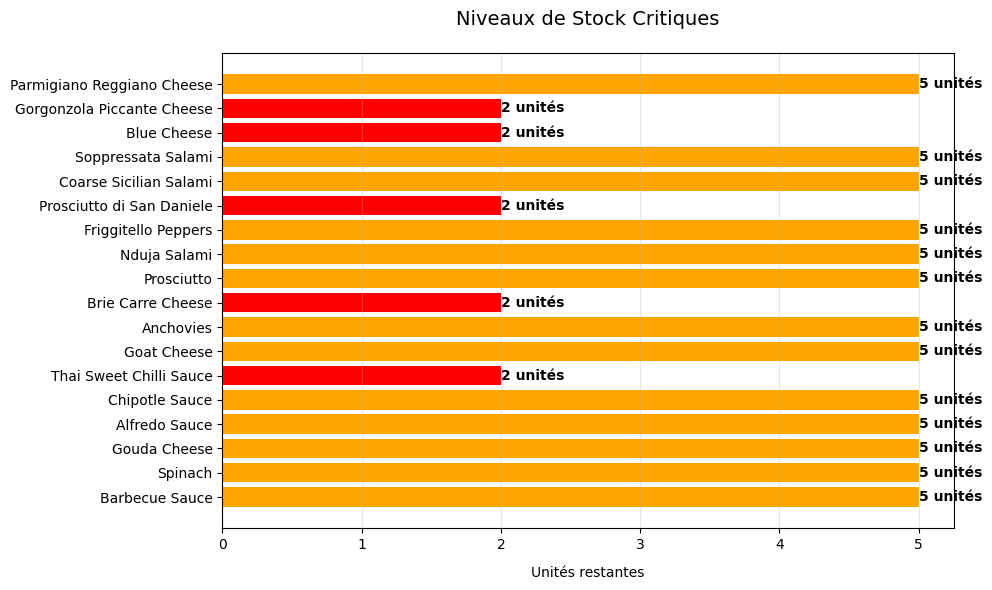


💡 Suggestions de réapprovisionnement:


,Ingrédient,Stock actuel,Quantité recommandée
0,Barbecue Sauce,5,20
1,Spinach,5,20
2,Gouda Cheese,5,20
3,Alfredo Sauce,5,20
4,Chipotle Sauce,5,20
5,Thai Sweet Chilli Sauce,2,20
6,Goat Cheese,5,20
7,Anchovies,5,20
8,Brie Carre Cheese,2,20
9,Prosciutto,5,20



📊 VISUALISATION COMPLÈTE DES STOCKS


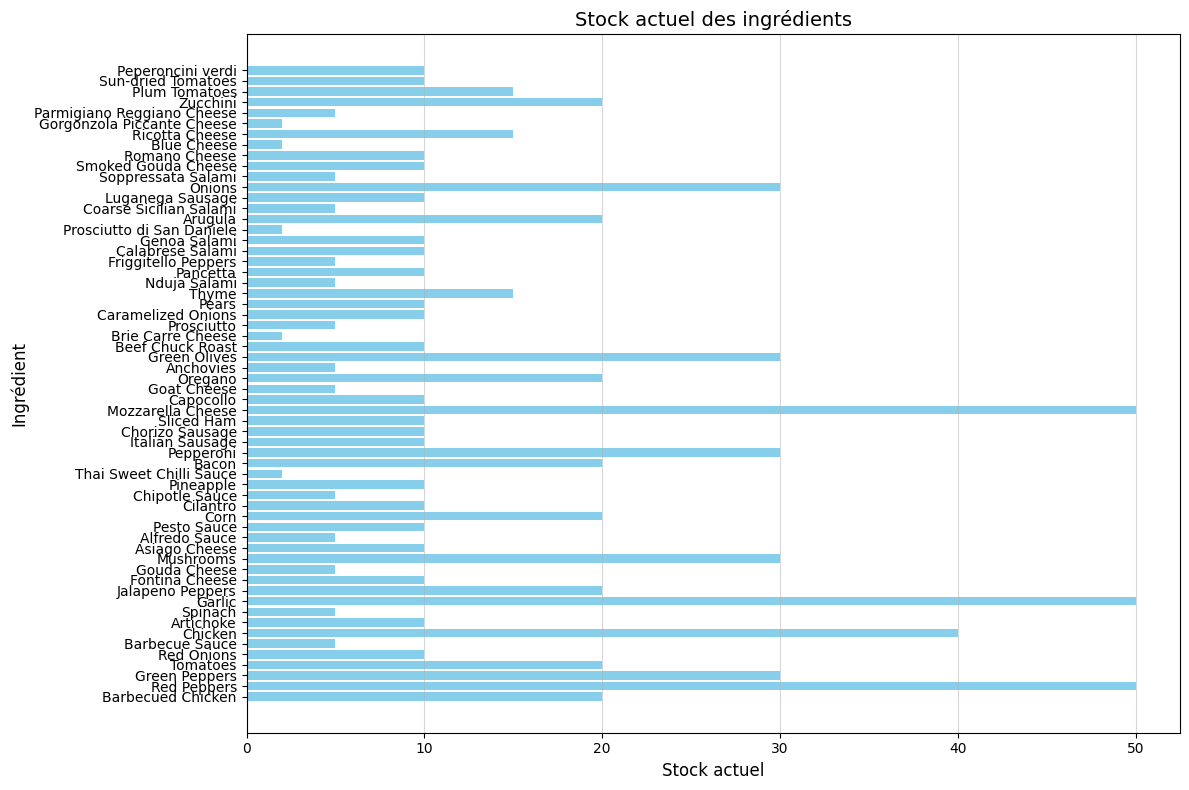


🔌 Connexion à la base de données fermée


In [22]:
def main():
    """
    Fonction principale améliorée :
    1. Se connecte à la base de données SQLite
    2. Détecte et affiche les pénuries avec une visualisation enrichie
    3. Visualise les stocks complets
    4. Ferme proprement la connexion
    """
    conn = None
    try:
        # Connexion à la base
        conn = sqlite3.connect("pizza.db")
        print("🔌 Connexion à la base de données établie")

        # Détection des pénuries
        penuries_df = detecter_penuries(conn)
        
        # Affichage amélioré des pénuries
        if not penuries_df.empty:
            print("\n🚨 ANALYSE DES PÉNURIES")
            print("="*40)
            
            # Création d'un style conditionnel
            def color_stock(val):
                color = 'red' if val < 5 else 'orange' if val < 10 else 'yellow'
                return f'color: {color}; font-weight: bold'
            
            # Affichage stylisé
            styled_df = penuries_df.style \
                .map(color_stock, subset=['Stock actuel']) \
                .bar(subset=['Stock actuel'], color='#ff6961') \
                .set_caption("Ingrédients en pénurie - Niveaux de stock critiques")
            
            display(styled_df)
            
            # Graphique des pénuries
            plt.figure(figsize=(10, 6))
            bars = plt.barh(penuries_df['Ingrédient'], 
                           penuries_df['Stock actuel'],
                           color=['red' if x < 5 else 'orange' for x in penuries_df['Stock actuel']])
            
            plt.title('Niveaux de Stock Critiques', pad=20, fontsize=14)
            plt.xlabel('Unités restantes', labelpad=10)
            plt.grid(axis='x', alpha=0.3)
            
            # Ajout des valeurs sur les barres
            for bar in bars:
                width = bar.get_width()
                plt.text(width, bar.get_y() + bar.get_height()/2, 
                         f'{width} unités', 
                         ha='left', va='center', fontweight='bold')
            
            plt.tight_layout()
            plt.show()
            
            # Suggestions de réappro
            print("\n💡 Suggestions de réapprovisionnement:")
            suggestions = penuries_df.copy()
            suggestions['Quantité recommandée'] = suggestions['Stock actuel'].apply(
                lambda x: max(20, x * 4))  # On recommande 4x le stock actuel ou 20 minimum
            
            display(suggestions.style
                   .bar(subset=['Quantité recommandée'], color='#77dd77')
                   .set_caption("Quantités de réapprovisionnement recommandées"))
            
        else:
            print("\n✅ Aucun ingrédient en pénurie - Stocks suffisants")

        # Visualisation complète des stocks
        print("\n📊 VISUALISATION COMPLÈTE DES STOCKS")
        visualiser_stocks(conn)

    except sqlite3.Error as e:
        print(f"\n❌ Erreur SQLite : {e}")
    except Exception as e:
        print(f"\n❌ Erreur inattendue : {e}")
    finally:
        if conn:
            conn.close()
            print("\n🔌 Connexion à la base de données fermée")


if __name__ == "__main__":
    main()